In [1]:
import pandas as pd
import numpy as np
import seaborn
%pylab notebook

import hashlib
import humanhash

Populating the interactive namespace from numpy and matplotlib


# Tablas Pivote

Es muy común la agrupación de información en formato 'stack' donde tenemos filas de datos que demuestran una correlación entre dos sets de valores.

Las tablas pivote son una forma de re-ordenar los datos en una estructura tabular donde podemos agrupar los valores convirtiendo las tuplas entre valores numéricos.

En este caso de ejemplo, crearemos un dataset de prueba con la diversidad de restaurantes en varias ciudades centroamericanas. En esta vamos a comenzar a trabajar con dos columnas, una donde describe cada ciudad y la otra con la variedad de cocina disponible en cada una.

In [2]:
data_restaurantes = {
    'ciudades': ['Guatemala','Guatemala','Guatemala','Guatemala','Guatemala','Guatemala','San José','San José','San José','San José','San José','San Salvador','San Salvador','San Salvador'],
    'culinaria': ['Chapina','Chapina','China','Thai','Italiana','Chapina','Italiana','China','Tica','Chapina','Tica','Tica','Italiana','China']
}

restaurantes_dataframe_pares = pd.DataFrame(data_restaurantes)
restaurantes_dataframe_pares

,ciudades,culinaria
0,Guatemala,Chapina
1,Guatemala,Chapina
2,Guatemala,China
3,Guatemala,Thai
4,Guatemala,Italiana
5,Guatemala,Chapina
6,San José,Italiana
7,San José,China
8,San José,Tica
9,San José,Chapina


Podemos ver entonces este listado de valores, tupla por tupla. Que tal si queremos contar la presencia de cada tipo de cocina en cada región. Probemos utilizando entonces el comando [DataFrame.pivot_table](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.pivot.html) de Pandas.

Este pide unos cuantos argumentos los que podemos ver en la documentación. Unos cuantos son obvios, como el definir las filas y columnas que esperamos de la tabla objetivo.
Sin embargo, lo más notable es que ya que los tipos de datos que estamos utilizando no son numéricos, es necesario que definamos una funcion de agrupación que nos permita contar la cantidad de instancias de cada combinación.

In [3]:
def funcion_agrupacion(elemento):
    return True

agrupacion_culinaria = restaurantes_dataframe_pares.pivot_table(
    index=["ciudades"],
    columns="culinaria",
    aggfunc=funcion_agrupacion,
    fill_value=False)
agrupacion_culinaria

culinaria,Chapina,China,Italiana,Thai,Tica
ciudades,,,,,
Guatemala,True,True,True,True,False
San José,True,True,True,False,True
San Salvador,False,True,True,False,True


Hmm, esto ya se ve con la forma que queremos, sin embargo solo nos muestra la presencia o ausencia de algún tipo de cocina. Esto es fácil de explicar ya que definimos nuestra función de agrupación como retornar True si existe presencia a retornar False si No. ¿Qué tal si hacemos una mejor función de agrupación?

In [24]:
def funcion_agrupacion(elemento):
    '''Contemos cuantas instancias de cada tupla existen.'''
    ## El comando len(iterable) cuenta la cantidad de elementos que tiene el objeto iterable que le pasemos
    ## los elementos iterables pueden ser listas normales, Series de NumPy o Pandas, o diccionarios y otros tipos de datos.
    return len(elemento)
agrupacion_culinaria = restaurantes_dataframe_pares.pivot_table(index=["ciudades"], columns="culinaria", aggfunc=lambda x: funcion_agrupacion(x), fill_value=0)
agrupacion_culinaria

estrellas                         
culinaria      Chapina China Italiana Thai Tica
ciudades                                       
Guatemala            3     1        1    1    0
San José             1     1        1    0    2
San Salvador         0     1        1    0    1

¡Genial! Ahora ya tenemos agrupadas estas de una forma coherente. Ahora ya podemos seguir manipulando y editando estos datos.
Pero, ¿qué tal si hacemos un poco más simple esta llamada? Al final nuestra función de agrupación lo unico que hace es contar la cantidad de tuplas sobre las cuales aplica el pivote. ¿Qué tal si lo hacemos un poco más simple?

In [5]:
agrupacion_culinaria = restaurantes_dataframe_pares.pivot_table(
    index=["ciudades"], 
    columns="culinaria", 
    aggfunc=len, ## Enviamos directamente la función de agrupación. Entre otras funcionas de agrupacíon útiles está np.sum (la función de suma de NumPy) y np.mean (media)
    fill_value=0)
agrupacion_culinaria

culinaria,Chapina,China,Italiana,Thai,Tica
ciudades,,,,,
Guatemala,3,1,1,1,0
San José,1,1,1,0,2
San Salvador,0,1,1,0,1


Claro, la tabla resultante se comporta exactamente igual y tiene todas las propiedades nativas de los DataFrames. ¿Qué tal si limitamos la query a solo los lugares en ciudad de Guatemala?

In [6]:
agrupacion_culinaria.query('ciudades == ["Guatemala"]')

culinaria,Chapina,China,Italiana,Thai,Tica
ciudades,,,,,
Guatemala,3,1,1,1,0


In [32]:
help(restaurantes_dataframe_pares.pivot_table)

Help on method pivot_table in module pandas.core.reshape.pivot:

pivot_table(values=None, index=None, columns=None, aggfunc='mean', fill_value=None, margins=False, dropna=True, margins_name='All') method of pandas.core.frame.DataFrame instance
    Create a spreadsheet-style pivot table as a DataFrame. The levels in the
    pivot table will be stored in MultiIndex objects (hierarchical indexes) on
    the index and columns of the result DataFrame
    
    Parameters
    ----------
    data : DataFrame
    values : column to aggregate, optional
    index : column, Grouper, array, or list of the previous
        If an array is passed, it must be the same length as the data. The list
        can contain any of the other types (except list).
        Keys to group by on the pivot table index.  If an array is passed, it
        is being used as the same manner as column values.
    columns : column, Grouper, array, or list of the previous
        If an array is passed, it must be the same len

In [33]:
## Con el argumento Margins, Panda calcula los valores sumados de los totales por agrupación.
agrupacion_culinaria_m = restaurantes_dataframe_pares.pivot_table(
    index=["ciudades"],
    columns="culinaria",
    aggfunc=len,
    fill_value=0,
    margins=True,
    margins_name="Total")
agrupacion_culinaria_m

estrellas                                  
culinaria      Chapina China Italiana  Thai  Tica  Total
ciudades                                                
Guatemala        3.000 1.000    1.000 1.000 0.000  6.000
San José         1.000 1.000    1.000 0.000 2.000  5.000
San Salvador     0.000 1.000    1.000 0.000 1.000  3.000
Total            4.000 3.000    3.000 1.000 3.000 14.000

## Múltiples Valores y Múltiples Indices
¿Qué tal si tenemos datos que tienen una estructura Jerárquica inherente? Podemos utilizar la misma forma de multi indexación que vimos en el seminario pasado, lo importante es que a la hora de la definición del índice, Pandas es capaz de manipularlos e inteligentemente ordenar los niveles acorde.

In [8]:
restaurantes_dataframe_pares['estrellas'] = [5,3,3,5,3,1,2,2,4,3,4,3,2,3]
restaurantes_dataframe_estrellas = restaurantes_dataframe_pares
restaurantes_dataframe_estrellas

,ciudades,culinaria,estrellas
0,Guatemala,Chapina,5
1,Guatemala,Chapina,3
2,Guatemala,China,3
3,Guatemala,Thai,5
4,Guatemala,Italiana,3
5,Guatemala,Chapina,1
6,San José,Italiana,2
7,San José,China,2
8,San José,Tica,4
9,San José,Chapina,3


Pivotando sobre la especialidad culinaria y estrellas, podemos las ciudades con la mayor oferta culinaria, o cuales tienen el mejor promedio de estrellas.

In [34]:
agrupacion_culinaria_promedio_estrellas = restaurantes_dataframe_estrellas.pivot_table(
    index=["ciudades"], 
    values=["culinaria", "estrellas"], 
    aggfunc={"culinaria":len,"estrellas":np.mean},
    fill_value=0)
agrupacion_culinaria_promedio_estrellas

,culinaria,estrellas
ciudades,,
Guatemala,6,3.333
San José,5,3.000
San Salvador,3,2.667


¿Qué tal si queremos ver cuantas estrellas en promedio tienen los restaurantes, por clase de comida, por ciudad?

In [38]:
agrupacion_culinaria_por_estrellas = restaurantes_dataframe_estrellas.pivot_table(
    index=["culinaria"], 
    values=["estrellas"], 
    columns=["estrellas"],
    aggfunc={"estrellas":np.mean},
    fill_value=0)
agrupacion_culinaria_por_estrellas

estrellas            
estrellas         1  2  3  4  5
culinaria                      
Chapina           1  0  3  0  5
China             0  2  3  0  0
Italiana          0  2  3  0  0
Thai              0  0  0  0  5
Tica              0  0  3  4  0

In [37]:
agrupacion_culinaria_por_estrellas = restaurantes_dataframe_estrellas.pivot_table(
    index=["culinaria"], 
    values=["estrellas"], 
    columns=["estrellas"],
    aggfunc={"estrellas":len},
    fill_value=0)
agrupacion_culinaria_por_estrellas

estrellas            
estrellas         1  2  3  4  5
culinaria                      
Chapina           1  0  2  0  1
China             0  1  2  0  0
Italiana          0  2  1  0  0
Thai              0  0  0  0  1
Tica              0  0  1  2  0

Hmm... esto no es muy útil, solo nos dice tautológicamente, que los restaurantes de 'n' estrellas tienen 'n' estrellas. ¿Pueden ver porque el error?

In [11]:
agrupacion_culinaria_por_estrellas = restaurantes_dataframe_estrellas.pivot_table(
    index=["ciudades"], 
    values=["estrellas"], 
    columns=["culinaria"], ## Aqui es obvio ver que lo que queremos es diferenciar por variedad culinaria.
    aggfunc={"estrellas":np.mean},
    fill_value=0)
agrupacion_culinaria_por_estrellas

estrellas                         
culinaria      Chapina China Italiana Thai Tica
ciudades                                       
Guatemala            3     3        3    5    0
San José             3     2        2    0    4
San Salvador         0     3        2    0    3

<IPython.core.display.Javascript object>


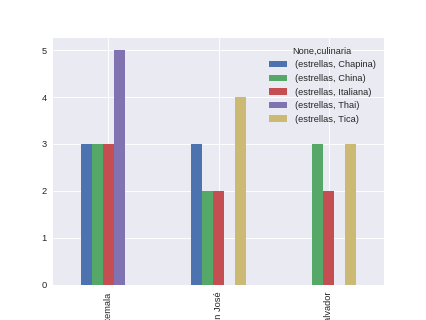

In [12]:
agrupacion_culinaria_por_estrellas.plot(kind="bar")

Entonces, recapitulando:

**¿De qué nos sirven las tablas pivote?**

**¿Que clase de operación representan?**

**¿En que casos podemos usarlas?**

# Agrupando, parte dos

Ya vimos algunos de los criterios básicos de agrupación en el primer webinar, ahora podemos avanzar un poco, combinando agrupación con pivote.

Tambien podemos usar [stack](https://pandas.pydata.org/pandas-docs/stable/reshaping.html), que es otra forma de agrupación basada en índices.

In [13]:
maga_fitosanitario = pd.read_csv("MAGA - CERTIFICADOS FITOSANITARIOS.csv")

In [14]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Vamos a limpiar un poco de información
def ofusca_nombre(nombre):
    return humanhash.humanize(hashlib.md5(nombre.encode("UTF-8")).hexdigest())

maga_fitosanitario["Solicitante"] = maga_fitosanitario["Solicitante"].map(ofusca_nombre)
maga_fitosanitario["Fecha Autorización"] = maga_fitosanitario["Fecha Autorización"].map(pd.Timestamp)

In [15]:
maga_fitosanitario.head()

,Incidente,Fecha Autorización,Solicitante,Permiso,Producto,Categoría,CIF $,Kg. Netos,Aduana,País procedencia,País origen,Otra fuente de origen
0,49,2014-04-04,sodium-pasta-glucose-mexico,142432,CASCARILLA DE ARROZ,MATERIA PRIMA PARA CONCENTRADOS,125.000,13607.79,MELCHOR DE MENCOS,Belice,Belice,NaN
1,50,2014-04-04,sodium-pasta-glucose-mexico,142425,CASCARILLA DE ARROZ,MATERIA PRIMA PARA CONCENTRADOS,75.000,8164.67,MELCHOR DE MENCOS,Belice,Belice,NaN
2,275,2014-07-04,robert-vermont-one-robert,142479,CASCARILLA DE ARROZ,MATERIA PRIMA PARA CONCENTRADOS,2584.100,34836.24,PEDRO DE ALVARADO,Nicaragua,Nicaragua,NaN
3,276,2014-07-04,robert-vermont-one-robert,142480,CASCARILLA DE ARROZ,MATERIA PRIMA PARA CONCENTRADOS,2584.100,34836.24,PEDRO DE ALVARADO,Nicaragua,Nicaragua,NaN
4,177,2014-07-04,zebra-missouri-arkansas-island,142478,HARINA DE TRIGO,HARINA DE TRIGO,81601.210,151800,TECUN UMAN,México,México,NaN


In [16]:
maga_fitosanitario.groupby("Producto").sum().sort_values("CIF $", ascending=False).head(20)

,Permiso,CIF $
Producto,,
MAIZ AMARILLO,53491946,183595249.360
HARINA DE SOYA,18899910,56391529.940
ARROZ EN GRANZA,3201212,24568825.500
HARINA DE TRIGO,76664602,24272107.260
AJONJOLI NATURAL,9215686,15985707.000
ARROZ GRANZA,15088878,13883822.800
ALGODON,9014988,12028250.890
ALGODON SIN CARDAR NI PEINAR,5222374,8151960.620
MADERA DE PINO (SECA),9285734,6498009.270


In [17]:
maga_productos_pivot = maga_fitosanitario.pivot_table(
    index=["Categoría", "Producto"], 
    values=["CIF $", "Permiso"], 
    aggfunc={"CIF $":np.sum,"Permiso":len},
    fill_value=0)

In [18]:
maga_productos_pivot

CIF $  \
Categoría               Producto                                                          
AJONJOLI                AJONJOLI DESCORTEZADO                                250093.750   
                        AJONJOLI NATURAL                                   10702707.000   
ALGODÓN                 ALGODON                                            12028250.890   
                        ALGODON (BLANQUEADO)                                  52969.250   
                        ALGODON (EN PACAS)                                    35604.510   
                        ALGODON (PACAS)                                       48087.740   
                        ALGODON (SIN CARDAR NI PEINAR)                      1934207.840   
                        ALGODON (SIN PEINAR NI CARDAR)                       507479.390   
                        ALGODON BLANQUEADO                                    52658.400   
                        ALGODON SI CARDAR NI PEINAR                           45158.090   
                        ALGODON SIN CARDAR NI PEINAR                        8151960.620   
                        ALGODON SIN PEINAR NI CARDAR                        2879479.080   
                        DESPERDICIO DE HILADOS DE ALGODON                     32070.300   
                        PACAS DE ALGODON                                     371093.740   
ALMIDON DE MAIZ         ALMIDON (GLOBE AA SPV/25 KG) DE MAIZ                  12500.000   
                        ALMIDON DE MAIZ                                      487747.500   
                        ALMIDON DE MAIZ (CORRUPAC)                            13515.000   
                        ALMIDON DE MAIZ AA                                     7075.000   
                        ALMIDON DE MAIZ CORRUPAC                              59038.460   
ALPISTE                 ALPISTE                                               54856.590   
ARBOLES NATURALES       SEMILLA DE TECA (TECTONA GRANDIS)                      1388.580   
                        SEMILLAS DE ARBOLES (Lluvia de oro y Papaya)             66.000   
                        SEMILLAS DE ARBOLES (Lluvia de oro, Papaya y St...      127.600   
ARROZ                   ARROZ                                               6111828.360   
                        ARROZ (PARBOIL)                                       97606.000   
                        ARROZ EN GRANO                                        20400.520   
                        ARROZ EN GRANZA                                    21791713.200   
                        ARROZ EN ORO                                          55507.880   
                        ARROZ ESCALDADO                                      240050.000   
                        ARROZ GRANZA                                       13883822.800   
...                                                                                 ...   
SUSTRATOS               FIBRA DE COCO                                         78753.320   
                        FIBRA DE COCO (SUSTRATO)                             117332.500   
                        FIBRA DE COCO TRATADA                                132302.370   
                        FIBRA DE ESTOPA DE COCO                                 375.000   
                        PEAT MOSS                                            655093.280   
                        PEAT MOSS (BOLSAS DE ENRAIZADORES)                    16425.000   
                        PEAT MOSS (SUSTRATO )                                  3258.670   
                        PEAT MOSS (SUSTRATO DARK VEGETABLE MIX)                7151.760   
                        PEAT MOSS (SUSTRATO DE TURBA)                         16068.000   
                        PEAT MOSS (SUSTRATO)                                  99434.250   
                        PEAT MOSS (TURBA)                                    213577.500   
                        PEAT MOSS SPHAGNUM (SUSTRATO DE TURBA)                

In [19]:
maga_aduanas_pivot = maga_fitosanitario.pivot_table(
    index=["País origen", "Aduana"], 
    values=["CIF $", "País procedencia"], 
    aggfunc={"CIF $":np.sum},
    fill_value=0)
maga_aduanas_pivot

CIF $
País origen          Aduana                              
ALEMANIA             EXPRESS AEREO             102326.890
                     PUERTO QUETZAL           1727517.610
                     SANTO TOMAS DE CASTILLA    10050.220
ARGENTINA            PEDRO DE ALVARADO           3166.080
                     PUERTO BARRIOS            163440.650
                     PUERTO QUETZAL            187991.750
                     SANTO TOMAS DE CASTILLA   410929.480
AUSTRALIA            EXPRESS AEREO              94350.000
                     PUERTO QUETZAL             26932.200
                     SANTO TOMAS DE CASTILLA   113750.000
                     TECUN UMAN                  5803.060
Alemania             EXPRESS AEREO              29503.210
Argentina            SANTO TOMAS DE CASTILLA    15510.000
BANGLADESH           PUERTO QUETZAL             48274.380
                     SANTO TOMAS DE CASTILLA    72000.000
BELGICA              EXPRESS AEREO              91348.900
                     PUERTO QUETZAL           1855830.570
                     TECUN UMAN                192549.940
BELICE               MELCHOR DE MENCOS         547047.370
BOLIVIA              PUERTO QUETZAL             91800.000
BRASIL               EXPRESS AEREO             121048.150
                     PUERTO BARRIOS            245407.820
                     SANTO TOMAS DE CASTILLA  3604767.180
BURKINA FASO         SANTO TOMAS DE CASTILLA    42888.000
Belice               MELCHOR DE MENCOS          45400.000
CANADÁ               EXPRESS AEREO                 72.110
                     PUERTO BARRIOS            551903.100
                     PUERTO QUETZAL            908538.010
                     SANTO TOMAS DE CASTILLA  1231395.590
CHAD                 PUERTO QUETZAL             35640.000
...                                                   ...
PERÚ                 EXPRESS AEREO            2572758.090
                     PUERTO QUETZAL            341275.700
                     SANTO TOMAS DE CASTILLA    49007.520
POLONIA              EXPRESS AEREO               6366.900
PORTUGAL             EXPRESS AEREO                667.320
Países Bajos         EXPRESS AEREO               6890.240
                     SANTO TOMAS DE CASTILLA   586587.070
Perú                 EXPRESS AEREO               2428.000
REINO UNIDO          EXPRESS AEREO                225.230
REPÚBLICA DOMINICANA SANTO TOMAS DE CASTILLA   734869.100
SRI LANKA            PUERTO QUETZAL            711008.530
                     SANTO TOMAS DE CASTILLA   665303.240
SUDÁFRICA            EXPRESS AEREO             310826.470
SUDÁN                PUERTO QUETZAL             36826.780
SUECIA               EXPRESS AEREO              72927.000
                     PUERTO QUETZAL           1827487.740
TAILANDIA            EXPRESS AEREO             226567.540
                     PUERTO QUETZAL             28765.000
TAIWAN               EXPRESS AEREO             205971.630
                     VALLE NUEVO                 1200.000
TANZANIA             PUERTO QUETZAL            330340.000
TURQUÍA              EXPRESS AEREO                262.950
URUGUAY              SANTO TOMAS DE CASTILLA  1485896.500
UZBEKISTÁN           SANTO TOMAS DE CASTILLA   106000.000
Uruguay              SANTO TOMAS DE CASTILLA    59007.800
VENEZUELA            PUERTO QUETZAL          13881240.000
                     SANTO TOMAS DE CASTILLA  1185600.000
VIETNAM              EXPRESS AEREO             163930.030
                     PUERTO QUETZAL            420550.000
YEMEN                PUERTO QUETZAL            167528.000

[186 rows x 1 columns]

Que tal si indagamos mas en las categorias que se importan de cada país.

In [20]:
maga_aduanas_pivot = maga_fitosanitario.pivot_table(
    index=["País origen", "Aduana", "Categoría"], 
    values=["CIF $"], 
    aggfunc={"CIF $":np.sum},
    fill_value=0)
maga_aduanas_pivot

CIF $
País origen Aduana                  Categoría                                 
ALEMANIA    EXPRESS AEREO           ESQUEJES RIZOMAS BULBOS          72024.570
                                    MATERIA PRIMA PARA ALIMENTOS     19900.530
                                    SEMILLAS DE FLORES                 475.790
                                    SEMILLAS DE HORTALIZA             9926.000
            PUERTO QUETZAL          MALTA                          1727517.610
            SANTO TOMAS DE CASTILLA MALTA                            10050.220
ARGENTINA   PEDRO DE ALVARADO       MAIZ PARA CONSUMO HUMANO          3166.080
            PUERTO BARRIOS          FRIJOL NEGRO                    139899.690
                                    FRIJOL PINTO                     23540.960
            PUERTO QUETZAL          FRUTAS                           60811.850
                                    GRANOS                          108570.000
                                    SEMILLAS DE FLORES               18609.900
            SANTO TOMAS DE CASTILLA GRANOS                          171416.960
                                    MAIZ PARA CONSUMO HUMANO         89333.000
                                    MAIZ PARA ELAB DE CONCENTRADOS   34881.500
                                    SEMILLAS DE FLORES               94778.020
                                    SEMILLAS DE HORTALIZA            20520.000
AUSTRALIA   EXPRESS AEREO           SEMILLAS DE HORTALIZA            94350.000
            PUERTO QUETZAL          MADERA CEPILLADA                 26932.200
            SANTO TOMAS DE CASTILLA SEMILLAS DE HORTALIZA           113750.000
            TECUN UMAN              MADERA ASERRADA                   5803.060
Alemania    EXPRESS AEREO           ESQUEJES RIZOMAS BULBOS          26028.210
                                    SEMILLAS DE HORTALIZA             3475.000
Argentina   SANTO TOMAS DE CASTILLA SEMILLAS DE FLORES               15510.000
BANGLADESH  PUERTO QUETZAL          TELA DE YUTE                     48274.380
            SANTO TOMAS DE CASTILLA TELA DE YUTE                     72000.000
BELGICA     EXPRESS AEREO           SEMILLAS DE HORTALIZA            91348.900
            PUERTO QUETZAL          MALTA                          1855830.570
            TECUN UMAN              ALMIDON DE MAIZ                  10500.000
                                    HARINA DE TRIGO                 162327.340
...                                                                        ...
SUDÁN       PUERTO QUETZAL          ESPECIAS                         36826.780
SUECIA      EXPRESS AEREO           SEMILLAS DE HORTALIZA            72927.000
            PUERTO QUETZAL          MALTA                          1827487.740
TAILANDIA   EXPRESS AEREO           ESQUEJES RIZOMAS BULBOS          10223.500
                                    FLORES                            4288.400
                                    SEMILLAS DE FLORES                   5.210
                                    SEMILLAS DE FRUTAS                 611.280
                                    SEMILLAS DE HORTALIZA           210959.570
                                    SEMOLA DE TRIGO                    479.580
            PUERTO QUETZAL          SEMILLAS DE HORTALIZA            28765.000
TAIWAN      EXPRESS AEREO           ESQUEJES RIZOMAS BULBOS           1152.000
                                    FLORES                           27781.000
                                    SEMILLAS DE FRUTAS               80970.400
                                    SEMILLAS DE HORTALIZA            96068.230
            VALLE NUEVO             FLORES                            1200.000
TANZANIA    PUERTO QUETZAL          SEMILLAS DE FLORES              330340.000
TURQUÍA     EXPRESS AEREO           SEMILLAS DE FLORES                 223.740
                                    SEMILLAS DE HORTALIZA               39.210
URUGUAY     SANTO TOMAS DE CASTILLA ARROZ   

In [21]:
maga_aduanas_pivot_top10 = maga_aduanas_pivot.sort_values("CIF $", ascending=False).head(10)

<IPython.core.display.Javascript object>


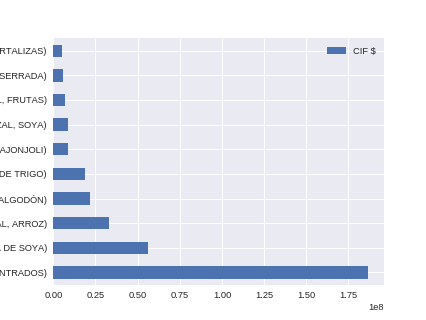

In [22]:
maga_aduanas_pivot_top10.plot(kind="barh")

Tambien es util mostrar la tabla, podemos ponerle un poco de estilo con la funcionalidad de [Seaborn + Pandas](https://pandas.pydata.org/pandas-docs/stable/style.html)

In [23]:
cm_paleta_verde = seaborn.light_palette("green", as_cmap=True)
s = maga_aduanas_pivot_top10.style.background_gradient(cmap=cm_paleta_verde)
s